In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import copy

import open3d as o3d
from open3d.visualization import draw_geometries

from process_bag import get_images
from utils import get_o3d_intrinsics, colordepth_to_rgbd, rgbd_to_pcd, remove_outliers

depth_intrinsics, color_intrinsics = get_o3d_intrinsics()

In [ ]:
from rembg import remove

In [ ]:
# Chessboard size
cb_counts = (4, 7)
cb_scale = 2
cb_size = 0.033 * cb_scale

# Rendering settings
voxel_size = 0.02
camera_size = 2 * cb_size
# origin_size = 4 * cb_size
origin_size = 1

kwargs = dict(
    zoom=0.5,
    front=[0.0, 0.0, -1.0],
    lookat=[0.0, 0.0, 0.0],
    up=[1.0, 0, 0],
)
kwargs = dict(
    zoom=1.0,
    front=[0.0, 0.0, -1.0],
    lookat=[0.0, 0.0, 0.0],
    up=[0, 1.0, 0],
)

data_name = "books_2"
data_name_raw = data_name.split("_")[0]
data_folder = f"data/{data_name}/"

color_fp = os.path.join(data_folder, "color.npy")
depth_fp = os.path.join(data_folder, "depth.npy")
color_single_fp = os.path.join(data_folder, "color_single.npy")
depth_single_fp = os.path.join(data_folder, "depth_single.npy")

### Pose Estimation

In [ ]:
# Load/Process Data
def get_imgs(color_fp, depth_fp, start_idx, end_idx, align=True):
    if os.path.exists(color_fp) and os.path.exists(depth_fp):
        color_imgs = np.load(color_fp)
        depth_imgs = np.load(depth_fp)
    else:
        color_imgs = []
        depth_imgs = []
        fps = sorted(glob.glob(f'{data_folder}/bags/*.bag'))
        for i, fp in enumerate(fps):
            if not os.path.exists(fp):
                continue
            print(f"Processing bag {i+1}/{len(fps)} {fp}")
            color_img, depth_img = get_images(
                start_idx=start_idx,
                end_idx=end_idx,
                bag_fp=fp,
                align=align,
                median=True
            )
            color_imgs.append(color_img)
            depth_imgs.append(depth_img)
        color_imgs = np.stack(color_imgs)
        depth_imgs = np.stack(depth_imgs)
        np.save(color_fp, color_imgs)
        np.save(depth_fp, depth_imgs)
    return color_imgs, depth_imgs

color_imgs, depth_imgs = get_imgs(color_fp, depth_fp, 0, 30)
color_imgs_single, depth_imgs_single = get_imgs(
    color_single_fp, depth_single_fp, 5, 6)

color_imgs.shape, depth_imgs.shape, color_imgs_single.shape, depth_imgs_single.shape

In [ ]:
def finetune_corners(gray, corners, size=6):
    corners2 = cv2.cornerSubPix(gray,corners,(size, size),(-1,-1),criteria)
    # Arrange corner order
    x1, y1 = corners2[0, 0]
    x2, y2 = corners2[-1, 0]
    # print(x1, x2, y1, y2)
    flip = False
    if x1 > x2 or y1 < y2:
        corners2 = corners2[::-1]
        flip = True
    return corners2, flip

In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.01)

# Define object points
objp = np.zeros((cb_counts[0]*cb_counts[1],3), np.float32)
objp[:,:2] = np.mgrid[0:cb_counts[0],0:cb_counts[1]].T.reshape(-1,2)
objp *= cb_size

In [ ]:
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
used_idxs = [] # Indices of images used
for i in tqdm(range(color_imgs.shape[0])):
    gray = cv2.cvtColor(color_imgs[i], cv2.COLOR_RGB2GRAY)
    gray_single = cv2.cvtColor(color_imgs_single[i], cv2.COLOR_RGB2GRAY)

    # Find and refine corners
    flags = cv2.CALIB_CB_EXHAUSTIVE + cv2.CALIB_CB_NORMALIZE_IMAGE
    ret, corners = cv2.findChessboardCornersSB(gray_single, cb_counts, flags=flags)
    if ret == False:
        ret, corners = cv2.findChessboardCornersSB(gray, cb_counts, flags=flags)
    if ret == True:
        corners, flip = finetune_corners(gray, corners)
        if not flip:
            print("Flipped", i)
        used_idxs.append(i)
        objpoints.append(objp)
        imgpoints.append(corners)

In [ ]:
n = len(used_idxs)
print(f"Found {n} images with checkerboard corners")

In [ ]:
color_imgs = color_imgs[used_idxs]
depth_imgs = depth_imgs[used_idxs]
color_imgs_single = color_imgs_single[used_idxs]
depth_imgs_single = depth_imgs_single[used_idxs]

# Update files
np.save(color_fp, color_imgs)
np.save(depth_fp, depth_imgs)
np.save(color_single_fp, color_imgs_single)
np.save(depth_single_fp, depth_imgs_single)

color_imgs.shape, depth_imgs.shape

In [ ]:
def show_imgs(imgs, titles=None, width=2):
    if titles is not None: assert len(imgs) == len(titles)
    f = lambda x: (x + width - 1) // width
    n = len(imgs)
    fig, axs = plt.subplots(f(n), width, figsize=(16, 6*f(n)))
    for i, ax in enumerate(axs.flatten()):
        if i >= n: break
        ax.imshow(imgs[i])
        if titles is not None: 
            ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot corners
plot_data = []
for i in range(n):
    try:
        img_tmp = cv2.drawChessboardCorners(
            color_imgs[i].copy(), cb_counts, imgpoints[i], True)
        
        # Calculate reprojection error
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            [objpoints[i]], [imgpoints[i]], img_tmp.shape[:-1][::-1], None, None)
        mat_err = np.linalg.norm(mtx - color_intrinsics.intrinsic_matrix)
        title = f"Image {i} {mat_err:.2f}"
        plot_data.append((mat_err, img_tmp, title, i))
    except Exception as e:
        print(e)
        continue

In [ ]:
# Sort by error and take top k
k = 10
plot_data.sort(key=lambda x: x[0], reverse=True)
plot_filt = plot_data[:k]
plot_imgs = [x[1] for x in plot_filt]
plot_titles = [x[2] for x in plot_filt]
plot_idxs = [x[3] for x in plot_filt]
show_imgs(plot_imgs, plot_titles)

In [ ]:
h, w, _ = color_imgs[0].shape
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, (w, h), None, None)

estimated_intrinsics = o3d.camera.PinholeCameraIntrinsic()
estimated_intrinsics.intrinsic_matrix = mtx

print(color_intrinsics.intrinsic_matrix)
print()
print(estimated_intrinsics.intrinsic_matrix)
dist

In [ ]:
def draw_axis(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    corner = (int(corner[0]), int(corner[1]))
    imgpts = np.int32(imgpts).reshape(-1,2)

    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

In [ ]:
# Note the negative z axis
axis = np.float32([[1,0,0], [0,1,0], [0,0,-1]]).reshape(-1,3) * cb_size * 4

rvecs_lst = []
tvecs_lst = []
plot_coords = []
# for i in tqdm(range(n)):
for i in plot_idxs:
    try:
        img_tmp = color_imgs[i].copy()

        # Find the rotation and translation vectors.
        rvec = rvecs[i].copy()
        tvec = tvecs[i].copy()
        # retval, rvec, tvec, inliers = cv2.solvePnPRansac(
        #     objp, imgpoints[i], mtx, dist, 
        #     rvec=rvec, 
        #     tvec=tvec,
        #     useExtrinsicGuess=True,
        #     iterationsCount=1000,
        #     reprojectionError=8, 
        #     confidence=0.99
        # )
        retval, rvec, tvec = cv2.solvePnP(
            objp, imgpoints[i], mtx, dist, 
            rvec=rvec, 
            tvec=tvec,
            useExtrinsicGuess=True,
        )
        # Check allclose
        # print(i, np.allclose(rvec, rvecs[i]), np.allclose(tvec, tvecs[i]))

        # project 3D points to image plane
        imgpts, _ = cv2.projectPoints(axis, rvec, tvec, mtx, dist)
        img_tmp = draw_axis(img_tmp, imgpoints[i], imgpts)
        plot_coords.append(img_tmp)

        rvecs_lst.append(rvec)
        tvecs_lst.append(tvec)
    except Exception as e:
        print(e)
        continue

In [ ]:
# i1, i2 = 128, 110
# idx1, idx2 = plot_idxs.index(i1), plot_idxs.index(i2)
# # show_imgs([plot_imgs[i], plot_imgs[i+1], plot_coords[i], plot_coords[i+1]])
# show_imgs([plot_imgs[idx1], plot_coords[idx1], plot_imgs[idx2], plot_coords[idx2]])

In [ ]:
# show_imgs([plot_imgs[i] for i in plot_idxs], plot_titles)
show_imgs(plot_coords, plot_titles)

In [ ]:
# Turn lists into extrinsic parameters
# rvecs = np.array(rvecs_lst)
# tvecs = np.array(tvecs_lst)
rvecs = np.array(rvecs)
tvecs = np.array(tvecs)

# Turn into 4x4 extrinsic matrices
w2c_exts = np.zeros((len(rvecs), 4, 4))
c2w_exts = np.zeros((len(rvecs), 4, 4))
for i in range(len(rvecs)):
    R, _ = cv2.Rodrigues(rvecs[i])
    w2c_exts[i, :3, :3] = R
    w2c_exts[i, :3, 3] = tvecs[i].T
    w2c_exts[i, 3, 3] = 1

    # world to camera -> camera to world
    c2w_exts[i] = np.linalg.inv(w2c_exts[i])
c2w_exts.shape

In [ ]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=origin_size, origin=[0,0,0])

# Draw camera locations and rotations
cameras = []
pcds_align = []
pcds_full = []

intrinsics = color_intrinsics
# intrinsics = estimated_intrinsics
for c2w_ext, color_img, depth_img in zip(c2w_exts, color_imgs, depth_imgs):
    # Get the RGBD image
    rgbd_img = colordepth_to_rgbd(color_img, depth_img)
    
    # Create a camera frame
    camera = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=camera_size, origin=[0,0,0])
    camera.transform(c2w_ext)

    # Create a pointcloud
    pcd = rgbd_to_pcd(rgbd_img, intrinsics)
    # Scale the pointcloud
    pcd.scale(cb_scale, center=[0,0,0])
    pcds_full.append(pcd)

    # Downsample and Align
    pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
    pcd.transform(c2w_ext)
    
    # Add to lists
    cameras.append(camera)
    pcds_align.append(pcd)

In [ ]:
draw_geometries(
    pcds_align + [origin] + cameras, 
    **kwargs
)
# draw_geometries(
#     pcds_full + [origin] + cameras,
#     **kwargs
# )
# draw_geometries(
#     [origin] + cameras, 
#     **kwargs
# )

In [ ]:
# Save the pointclouds and extrinsics
!mkdir -p {data_folder}/plys
!rm -rf {data_folder}/plys/*

for i, (pcd, c2w_ext) in enumerate(zip(pcds_full, c2w_exts)):
    fp = f"{data_folder}/plys/pcd_{i:03}.ply"
    o3d.io.write_point_cloud(fp, pcd)

np.save(f"{data_folder}/c2w_extrinsics.npy", c2w_exts)
np.save(f"{data_folder}/rvecs.npy", rvecs)
np.save(f"{data_folder}/tvecs.npy", tvecs)

### Denoise Pointclouds

In [ ]:
pcd_fps = sorted(glob.glob(f"{data_folder}/plys/pcd_*.ply"))

# Seed and split into train, val, test
np.random.seed(0)
n = len(pcd_fps)
idxs = np.arange(n)
np.random.shuffle(idxs)

train_percent, val_percent, test_percent = 0.6, 0.2, 0.2
train_idxs = idxs[:int(n*train_percent)]
val_idxs = idxs[int(n*train_percent):int(n*(train_percent+val_percent))]
test_idxs = idxs[int(n*(train_percent+val_percent)):]

In [ ]:
# Load extrinsics
c2w_exts = np.load(f"{data_folder}/c2w_extrinsics.npy")
rvecs = np.load(f"{data_folder}/rvecs.npy")
tvecs = np.load(f"{data_folder}/tvecs.npy")

# Load the pointclouds and align
pcds_full = []
for i, fp in enumerate(pcd_fps):
    pcd = o3d.io.read_point_cloud(fp)
    pcd.transform(c2w_exts[i])
    pcds_full.append(pcd)

In [ ]:
# pcds_train = [pcds_full[i] for i in train_idxs]
# pcds_val = [pcds_full[i] for i in val_idxs]
# pcds_test = [pcds_full[i] for i in test_idxs]

# c2w_exts_train = c2w_exts[train_idxs]
# c2w_exts_val = c2w_exts[val_idxs]
# c2w_exts_test = c2w_exts[test_idxs]

# len(pcds_train), len(pcds_val), len(pcds_test)

In [ ]:
def o3d_vis(pcds, c2w_exts, align=True, use_kwargs=True, both=False):
    # Test Alignment
    pcds_align = []
    cameras = []
    for i in range(len(pcds)):
        pcd = copy.deepcopy(pcds[i])
        c2w_ext = c2w_exts[i]

        if align:
            pcd.transform(c2w_ext)
        pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
        pcds_align.append(pcd)

        # Camera frame
        camera = o3d.geometry.TriangleMesh.create_coordinate_frame(
            size=camera_size, origin=[0,0,0])
        camera.transform(c2w_ext)
        cameras.append(camera)

    # origin coords
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=origin_size, origin=[0,0,0])
    origin2 = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=origin_size, origin=[0,0,0])
    origin2.rotate(R=np.array([[-1,0,0],[0,-1,0],[0,0,-1]]), center=[0,0,0])

    origins = [origin]
    if both:
        origins = [origin, origin2]

    if use_kwargs:
        o3d.visualization.draw_geometries(pcds_align + cameras + origins, 
        **kwargs)
    else:
        o3d.visualization.draw_geometries(pcds_align + cameras + origins)

In [ ]:
o3d_vis(pcds_full, c2w_exts, align=False)

In [ ]:
# nb_neighbors = 20
# std_ratio = 0.25
# nb_points = 25
# radius = 0.2

# voxel_size = 0.02

# def clean_pcds(pcds_full, c2w_exts, voxel_size=None):
#     pcds_clean = []
#     for i in tqdm(range(len(pcds_full))):
#         clean = pcds_full[i]
#         if voxel_size is not None:
#             clean = clean.voxel_down_sample(voxel_size=voxel_size)
        
#         clean = remove_outliers(
#             clean,
#             nb_neighbors=nb_neighbors,
#             std_ratio=std_ratio,
#             nb_points=nb_points,
#             radius=radius
#         )
#         clean.transform(c2w_exts[i])
#         pcds_clean.append(clean)        
#     return pcds_clean

# pcds_clean_train = clean_pcds(pcds_train, c2w_exts_train, voxel_size=voxel_size)
# pcds_clean_val = clean_pcds(pcds_val, c2w_exts_val, voxel_size=voxel_size)
# pcds_clean_test = clean_pcds(pcds_test, c2w_exts_test, voxel_size=voxel_size)

In [ ]:
# clean = pcds_train[0]
# print(clean)

# nb_neighbors = 20
# std_ratio = 0.25
# nb_points = 25
# radius = 0.15

# voxel_size = 0.045

# # Downsample
# clean = clean.voxel_down_sample(voxel_size=voxel_size)

# clean = remove_outliers(
#     clean,
#     nb_neighbors=nb_neighbors,
#     std_ratio=std_ratio,
#     nb_points=nb_points,
#     radius=radius
# )
# clean
# draw_geometries([clean])

### Crop Pointclouds

In [ ]:
o3d_vis(pcds_full, c2w_exts, align=False)

In [ ]:
# Define crop bounds
# end_1 = np.array([0.04, -0.62, -0.55]) * cb_scale
# end_2 = np.array([1.3, 0.5, 0.35]) * cb_scale

end_1 = np.array([0.2, -0.1, -0.15]) * cb_scale
end_2 = np.array([0.65, 0.4, 0.2]) * cb_scale

coord_1 = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.5, origin=[0,0,0])
coord_2 = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.5, origin=[0,0,0])
coord_1.translate(end_1)
coord_2.translate(end_2)

bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=end_1, max_bound=end_2)

def crop_pcds(pcds, bbox):
    pcds_crops = []
    for pcd in pcds:
        pcd_tmp = copy.deepcopy(pcd)
        pcds_crops.append(pcd.crop(bbox))
    return pcds_crops

# pcds_crop_train = crop_pcds(pcds_train, bbox)
# pcds_crop_val = crop_pcds(pcds_val, bbox)
# pcds_crop_test = crop_pcds(pcds_test, bbox)
pcds_crop = crop_pcds(pcds_full, bbox)

draw_geometries(pcds_crop + [coord_1, coord_2], **kwargs)

In [ ]:
# Clean 
nb_neighbors = 20
std_ratio = 0.01
nb_points = 60
radius = 0.1

voxel_size = 0.01

def clean_pcds(pcds_full, voxel_size=None):
    pcds_clean = []
    for i in tqdm(range(len(pcds_full))):
        clean = pcds_full[i]
        if voxel_size is not None:
            clean = clean.voxel_down_sample(voxel_size=voxel_size)
        
        clean = remove_outliers(
            clean,
            nb_neighbors=nb_neighbors,
            std_ratio=std_ratio,
            nb_points=nb_points,
            radius=radius
        )
        pcds_clean.append(clean)        
    return pcds_clean

pcds_clean = clean_pcds(pcds_crop, voxel_size=voxel_size)

# Fuse the point clouds and draw bounding box
pcd_fused_raw = o3d.geometry.PointCloud()
for pcd in pcds_clean:
    pcd_fused_raw += pcd

bbox = pcd_fused_raw.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)

In [ ]:
# Calculate all points in the bounding box defined by end_1 and end_2
end_1 = bbox.get_min_bound()
end_2 = bbox.get_max_bound()
ends = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            ends.append([
                end_1[0] if i == 0 else end_2[0],
                end_1[1] if j == 0 else end_2[1],
                end_1[2] if k == 0 else end_2[2]
            ])

ends = np.array(ends)
end_1, end_2

In [ ]:
ends_pcd = o3d.geometry.PointCloud()
ends_pcd.points = o3d.utility.Vector3dVector(ends)
ends_pcd.paint_uniform_color([0, 0, 1])

draw_geometries([pcd_fused_raw, bbox, ends_pcd], **kwargs)

In [ ]:
color = color_imgs[0].copy()
c2w = c2w_exts[0]
w2c = np.linalg.inv(c2w)
rvec, _ = cv2.Rodrigues(w2c[:3, :3])
tvec = w2c[:3, 3]

In [ ]:
# projectpoints
imgpts, _ = cv2.projectPoints(
    objectPoints=ends,
    rvec=rvec,
    tvec=tvec,
    cameraMatrix=mtx,
    distCoeffs=dist
)
# Round to int
imgpts = np.round(imgpts).astype(np.int32)

# Draw
for i in range(8):
    color = cv2.circle(color, tuple(imgpts[i].ravel()), 5, (0,255,0), -1)

plt.imshow(color)

In [ ]:
nb_neighbors = 60
std_ratio = 0.01
nb_points = 60
radius = 0.05

voxel_size = 0.01

pcd_fused = clean_pcds([pcd_fused_raw], voxel_size=voxel_size)[0]
bbox = pcd_fused.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)

In [ ]:
print(pcd_fused_raw)
print(pcd_fused)

In [ ]:
draw_geometries([pcd_fused, bbox], **kwargs)

In [ ]:
# # Filter out points that are too bright or too gray
# color_thresh = 0.5
# gray_thresh = 0.07

# pcds_filt = []
# for i in range(len(pcds_crop)):
#     pcd = pcds_crop[i]
#     colors = np.asarray(pcd.colors)
    
#     color_idxs = np.where(np.mean(colors, axis=1) > color_thresh)[0]
#     gray_idxs = np.where(np.max(colors, axis=1) - np.min(colors, axis=1) < gray_thresh)[0]
#     idxs = np.union1d(color_idxs, gray_idxs)
#     print(len(idxs))
#     pcd_filt = pcd.select_by_index(
#         idxs,
#         invert=True
#     )
#     pcds_filt.append(pcd_filt)


In [ ]:
# o3d.visualization.draw_geometries(pcds_filt + [coord_1, coord_2], **kwargs)

### Multiway Registration

In [ ]:
# From http://www.open3d.org/docs/latest/tutorial/Advanced/multiway_registration.html
def pairwise_registration(
        source, target, max_correspondence_distance_coarse,
        max_correspondence_distance_fine
    ):
    # print("Apply point-to-plane ICP")
    # Coarse ICP starting with identity matrix
    icp_coarse = o3d.pipelines.registration.registration_icp(
        source, 
        target, 
        max_correspondence_distance_coarse, 
        init = np.identity(4),
        estimation_method = o3d.pipelines.registration.TransformationEstimationPointToPlane()
    )
    # Fine ICP using the result of coarse ICP as initialization
    icp_fine = o3d.pipelines.registration.registration_icp(
        source, 
        target, 
        max_correspondence_distance_fine,
        init = icp_coarse.transformation,
        estimation_method = o3d.pipelines.registration.TransformationEstimationPointToPlane()
    )
    
    # Return the transformation matrix and information matrix
    transformation_icp = icp_fine.transformation
    information_icp = o3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(
        pcds, max_correspondence_distance_coarse,
        max_correspondence_distance_fine
    ):
    pose_graph = o3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in tqdm(range(n_pcds)):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], 
                pcds[target_id], 
                max_correspondence_distance_coarse,
                max_correspondence_distance_fine,
            )
            # print("Build o3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph

In [ ]:
# Align using cropped point clouds
max_correspondence_distance_coarse = voxel_size * 4
max_correspondence_distance_fine = voxel_size * 2
# with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Error) as cm:
    pose_graph = full_registration(pcds_filt,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)

In [ ]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0
)
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        pose_graph,
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option
    )

In [ ]:
pcds_align = []
for i in range(len(pcds_crop)):
    pcd = copy.deepcopy(pcds_crop[i])
    pcd.transform(pose_graph.nodes[i].pose)
    pcds_align.append(pcd)

In [ ]:
o3d.visualization.draw_geometries(pcds_crop, **kwargs)

In [ ]:
o3d.visualization.draw_geometries(pcds_align, **kwargs)

In [ ]:
for i in range(len(pcds_align)):
    print(np.round(pose_graph.nodes[i].pose, 3))
    print()

In [ ]:
# Display the camera poses
cameras = []
for i in range(len(pcds_clean)):
    size=voxel_size
    if i == 0:
        size=voxel_size*2
    cameras.append(o3d.geometry.TriangleMesh.create_coordinate_frame(size=size))
    cameras[i].transform(pose_graph.nodes[i].pose)
o3d.visualization.draw_geometries(cameras)

### Remove Backgrounds


In [ ]:
from sklearn.cluster import KMeans
from rembg import remove, new_session

In [ ]:
# Load/Process Data
color_imgs = np.load(color_fp)
depth_imgs = np.load(depth_fp)
n, h, w, c = color_imgs.shape
n, h, w, c

In [ ]:
# Center crop
crop_size = min(h, w)
color_imgs_crop = color_imgs[:, 
    (h-crop_size)//2:(h+crop_size)//2, 
    (w-crop_size)//2:(w+crop_size)//2, 
:]
depth_imgs_crop = depth_imgs[:,
    (h-crop_size)//2:(h+crop_size)//2,
    (w-crop_size)//2:(w+crop_size)//2,
]

In [ ]:
session = new_session("isnet-general-use")

output_imgs = []
max_depth = 0
for i in tqdm(range(len(color_imgs_crop))):
    color_img = color_imgs_crop[i].copy()
    depth_img = depth_imgs_crop[i].copy()

    # Remove background
    color_img = remove(color_img).copy()
    # color_img = remove(color_img, session=session).copy()

    output_imgs.append(color_img)

    # Alpha mask
    alpha_mask = (color_img[:, :, 3] > alpha_thresh).astype(np.float32)
    masked_depth = depth_img * alpha_mask
    if masked_depth.max() > max_depth:
        max_depth = masked_depth.max()    
    
max_depth, len(output_imgs)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   84 1887 1053  253    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
79 [1107.2878, 1134.6375, 1163.1301, 1198.5029, 1232.405]
1370.8 1370.8


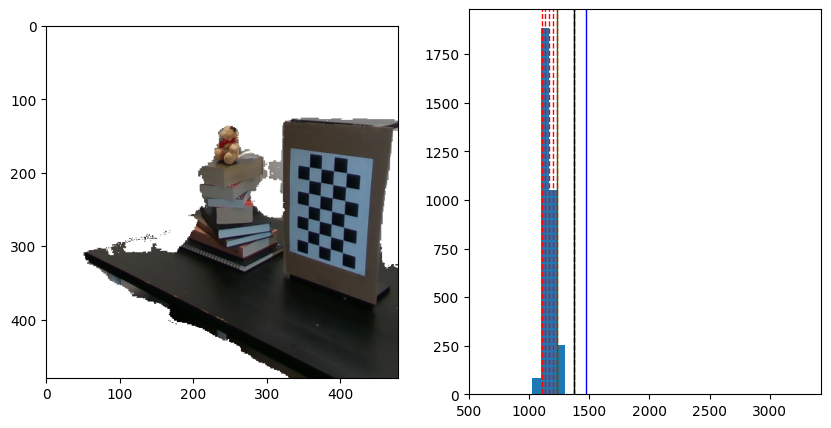

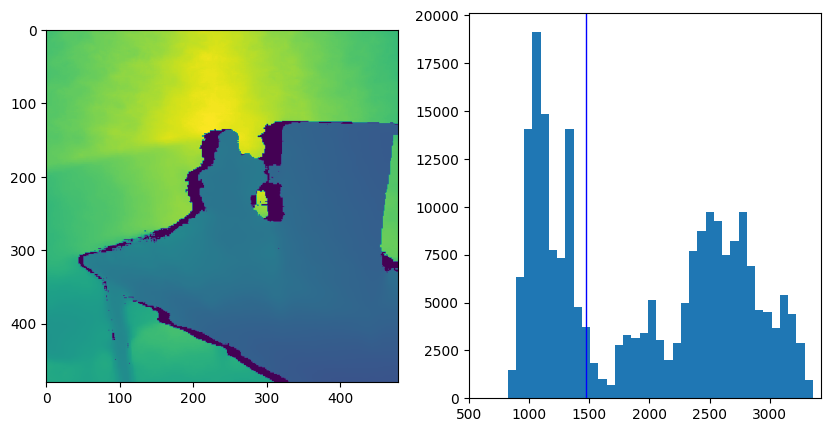

In [400]:
bins = 50
filt_imgs = []
for i, output_img in enumerate(output_imgs):
    if i < 79: continue
    color_img = color_imgs_crop[i].copy()
    depth_img = depth_imgs_crop[i].copy()
    h, w, c = color_img.shape

    # Alpha mask
    alpha_mask = (output_img[:, :, 3] > alpha_thresh).astype(np.float32)
    masked_depth = depth_img * alpha_mask
    non_zero_masked_depth = masked_depth[masked_depth > 0].flatten()
    n = len(non_zero_masked_depth)

    # KMeans
    kmeans = KMeans(n_clusters=5, n_init='auto').fit(non_zero_masked_depth.reshape(-1, 1))
    m_lst = sorted(kmeans.cluster_centers_.flatten())

    depth_idx = 1
    while depth_idx + 1 < len(m_lst) and \
            m_lst[depth_idx] + 400 >= m_lst[depth_idx+1]:
        depth_idx += 1
    mean_depth = m_lst[depth_idx]

    # Histogram
    counts, depths = np.histogram(
        non_zero_masked_depth, 
        bins=bins, 
        range=(0, max_depth)
    )
    depths = depths[1:]
    print(counts)

    # Find next 0 count
    idx1 = 0
    while depths[idx1] < mean_depth:
        idx1 += 1
    while counts[idx1]/n > 0.005:
        idx1 += 1
    depth_thresh_1 = depths[idx1]

    # Find next non-0 count
    idx2 = idx1
    while idx2 < len(depths) and counts[idx2]/n < 0.0005:
        idx2 += 1
    if idx2 == len(depths):
        depth_thresh_2 = depth_thresh_1
    else:
        depth_thresh_2 = depths[idx2]
    
    print(i, m_lst)
    print(depth_thresh_1, depth_thresh_2)
    depth_thresh = 0.75 * depth_thresh_1 + 0.25 * depth_thresh_2 + 100

    depth_mask = (depth_img <= depth_thresh).astype(np.uint8)
    zero_mask = (depth_img > 0).astype(np.uint8)
    mask = (depth_mask * zero_mask)

    # Add alpha channel
    color_img = np.concatenate([color_img, np.ones((h, w, 1))], axis=-1)
    color_img[:, :, 3] = mask * 255
    color_img = color_img.astype(np.uint8)
    filt_imgs.append(color_img)

    # Plot hist and img
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(color_img)
    ax[1].hist(non_zero_masked_depth, bins=bins, range=(0, max_depth))
    ax[1].axvline(depth_thresh_1, color='k', linestyle='dashed', linewidth=1)
    ax[1].axvline(depth_thresh_2, color='k', linewidth=1)
    ax[1].axvline(depth_thresh, color='b', linewidth=1)
    ax[1].axvline(mean_depth, color='g', linewidth=1)
    for m in m_lst:
        ax[1].axvline(m, color='r', linestyle='dashed', linewidth=1)
    ax[1].set_xlim(500, max_depth)
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # Depth image and entire histogram
    ax[0].imshow(depth_img)
    ax[1].hist(depth_img.flatten(), bins=bins, range=(0, max_depth))
    ax[1].axvline(depth_thresh, color='b', linewidth=1)
    ax[1].set_xlim(500, max_depth)
    plt.show()

    # plt.imshow(alpha_mask)
    # plt.imshow(masked_depth)
    # plt.imshow(color_img)
    # plt.show()
    
    break

In [ ]:
plt.imshow(color_imgs[0])

In [ ]:
plt.imshow(depth_imgs[0])

In [ ]:
# Find next 0 count
idx = 0
while depths[idx] < mean_depth:
    idx += 1
print(idx, depths[idx])
while idx < len(depths) and counts[idx]/n > 0.005:
    print(idx, depths[idx], counts[idx]/n)
    idx += 1
print(idx, depths[idx], counts[idx], counts[idx]/n)
depth_thresh = depths[idx]

In [ ]:
n

In [ ]:
counts[idx]/n

In [ ]:
counts

In [ ]:
plt.plot(depths[:-1], counts)
plt.axvline(depth_thresh, color='k', linestyle='dashed', linewidth=1)
plt.show()

In [ ]:
x

In [ ]:
color_imgs_train = color_imgs_crop[train_idxs]
color_imgs_val = color_imgs_crop[val_idxs]
color_imgs_test = color_imgs_crop[test_idxs]
color_imgs_train.shape, color_imgs_val.shape, color_imgs_test.shape

In [ ]:
# Pad to original size
pad_size = (max(h, w) - crop_size) // 2
# sample = 
plt.imshow(np.pad(color_imgs_train[0], 
    ((0, 0), (pad_size, pad_size), (0, 0)),
    mode='constant',
    constant_values=255))
plt.axis('off')
plt.show()

plt.imshow(color_imgs[train_idxs[0]])
plt.axis('off')
plt.show()

### Export for pointnerf

In [ ]:
# Visualize pcds_clean and cameras
# o3d_vis(pcds_clean_train, c2w_exts_train, align=True)

# pcds_clean_train = pcds_crops[0]
# o3d_vis(pcds_clean_train, c2w_exts_train, align=False)

In [ ]:
# x->y, y->z, z->x
ext_rot = np.array([
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1]
])
# x->z, y->x, z->y
ext_rot = np.array([
    [-1, 0, 0, 0.7],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])
# ext_rot = np.eye(4)

# Rotate 180 degrees around x axis
blender2cv = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

In [ ]:
def rotate_c2w_exts(c2w_exts):
    c2w_exts_rot = []
    for ext in c2w_exts:
        c2w_exts_rot.append(ext_rot @ ext @ blender2cv)
    return np.array(c2w_exts_rot)

# Rotate everything
c2w_exts_train_rot = rotate_c2w_exts(c2w_exts_train)
c2w_exts_val_rot = rotate_c2w_exts(c2w_exts_val)
c2w_exts_test_rot = rotate_c2w_exts(c2w_exts_test)

pcd_fused_rot = copy.deepcopy(pcd_fused)
pcd_fused_rot.transform(ext_rot)
bbox = pcd_fused_rot.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)

# Compute normals
pcd_fused_rot.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

In [ ]:
# Calculate furtherest camera
furthest_cam_idx = 0
furthest_dist = 0
for i in range(len(pcds_clean_train)):
    dist = np.linalg.norm(c2w_exts_train_rot[i][:3, 3])
    if dist > furthest_dist:
        furthest_dist = dist
        furthest_cam_idx = i
furthest_cam_idx, furthest_dist

In [ ]:
# Render camera poses
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

cameras = []
for i in range(len(pcds_clean_train)):
    size=0.2
    if i == 0:
        size*=2
    cameras.append(o3d.geometry.TriangleMesh.create_coordinate_frame(size=size))
    cameras[i].transform(c2w_exts_train_rot[i])

draw_geometries(cameras + [pcd_fused_rot, origin, bbox], **kwargs)

In [ ]:
# 4x4x4 box centered at origin
size = 5
box = o3d.geometry.TriangleMesh.create_box(width=size, height=size, depth=size)
box.compute_vertex_normals()
box.paint_uniform_color([0.9, 0.1, 0.1])
box.translate((-size/2, -size/2, -size/2))

draw_geometries([box, pcd_fused_rot] + cameras, **kwargs)

In [ ]:
" ".join(map(
    str,
    list(np.round(pcd_fused_rot.get_min_bound(), 3)) + \
        list(np.round(pcd_fused_rot.get_max_bound(), 3))
))

In [ ]:
# find camera_angle_x
final_height = 480
scale = final_height / color_intrinsics.height
focal = np.mean(color_intrinsics.get_focal_length())
print(focal, scale, focal * scale)
focal = focal * scale
camera_angle_x = 2 * np.arctan(0.5 * final_height / focal)
camera_angle_x

In [ ]:
folder_fp = f"pointnerf/data_src/nerf/nerf_synthetic_colmap/{data_name_raw}"
!mkdir -p $folder_fp/train
!mkdir -p $folder_fp/val
!mkdir -p $folder_fp/test
!mkdir -p $folder_fp/colmap_results/dense

In [ ]:
import json

def output_data(c2w_exts, color_imgs, camera_angle_x, split="train"):
    data = {
        "camera_angle_x": camera_angle_x,
        "frames": []
    }
    for i in range(len(c2w_exts)):
        frame = {
            "file_path": f"./{split}/r_{i}",
            "rotation": 0.0,
            "transform_matrix": c2w_exts[i].tolist()
        }
        data["frames"].append(frame)

        # Save image
        img_fp = f"{folder_fp}/{split}/r_{i}.png"
        cv_img = cv2.cvtColor(color_imgs[i], cv2.COLOR_RGB2BGRA)
        cv_img[:, :, 3] = 255
        cv2.imwrite(img_fp, cv_img)

    # Save data
    data_fp = f"{folder_fp}/transforms_{split}.json"
    with open(data_fp, 'w', encoding='utf-8') as outfile:
        json.dump(data, outfile, indent=4)

output_data(c2w_exts_train_rot, color_imgs_train, camera_angle_x, split="train")
output_data(c2w_exts_val_rot, color_imgs_val, camera_angle_x, split="val")
output_data(c2w_exts_test_rot, color_imgs_test, camera_angle_x, split="test")

In [ ]:
from plyfile import PlyData, PlyElement

def write_ply(pcd, fp, write_text=False):
    pts = np.asarray(pcd.points)
    normals = np.asarray(pcd.normals)
    colors = (np.asarray(pcd.colors) * 255).astype(np.uint8)

    x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
    nx, ny, nz = normals[:, 0], normals[:, 1], normals[:, 2]
    r, g, b = colors[:, 0], colors[:, 1], colors[:, 2]
    print(len(x), len(y), len(z), len(nx), len(ny), len(nz), len(r), len(g), len(b))

    pts = list(zip(x, y, z, nx, ny, nz, r, g, b))

    vertex = np.array(pts, dtype=[
        ('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
        ('nx', 'f4'), ('ny', 'f4'), ('nz', 'f4'),
        ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')
    ])

    el = PlyElement.describe(vertex, 'vertex')
    PlyData([el], text=write_text).write(fp)

In [ ]:
# Save Point Cloud
pcd_fp = f"{folder_fp}/colmap_results/dense/fused.ply"
# o3d.io.write_point_cloud(pcd_fp, pcd_fused_rot)
write_ply(pcd_fused_rot, pcd_fp, write_text=False)

In [ ]:
o3d.io.read_point_cloud(pcd_fp)
draw_geometries([o3d.io.read_point_cloud(pcd_fp), origin], **kwargs)

In [ ]:
copy_to = f"pointnerf/data_src/nerf/nerf_synthetic/{data_name_raw}/"
!mkdir -p $copy_to
!cp -r $folder_fp/* $copy_to

In [ ]:
!ls -l $folder_fp/train | head -n 10
!ls -l $folder_fp/colmap_results/dense
!ls -l $copy_to/train | head -n 10
!ls -l $copy_to/colmap_results/dense

In [ ]:
# points_path = "pointnerf/data_src/nerf/nerf_synthetic_colmap/guitar/colmap_results/dense/fused.ply"
points_path = "pointnerf/data_src/nerf/nerf_synthetic_colmap/chair/colmap_results/dense/fused.ply"

In [ ]:
import open3d as o3d
pcd_2 = o3d.io.read_point_cloud(points_path)
o3d.visualization.draw_geometries([pcd_2])

### Testing

In [ ]:
import json
import glob
import numpy as np
import os
import open3d as o3d

In [ ]:
# Draw camera locations and rotations
def draw_cameras(transforms_json_fp):
    with open(transforms_json_fp, "r") as f:
        transforms = json.load(f)

    blender2opencv = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    frames = transforms["frames"]
    extrinsic_matrices = [
        np.array(frame["transform_matrix"]) @ blender2opencv
    for frame in frames]

    camera_angle = transforms["camera_angle_x"]
    focal = 0.5 * 800 / np.tan(0.5 * camera_angle)

    # Create dummy intrinsics
    intrinsics = o3d.camera.PinholeCameraIntrinsic()
    intrinsics.set_intrinsics(512, 512, focal, focal, 256, 256)

    # Draw camera locations and rotations
    cameras = []
    for extrinsic_matrix in extrinsic_matrices:
        camera = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2)
        camera.transform(extrinsic_matrix)
        cameras.append(camera)
    return cameras

In [ ]:
ply_fp = f"pointnerf/data_src/nerf/nerf_synthetic_colmap/{data_name_raw}/colmap_results/dense/fused.ply"
transforms_json_fp = f"pointnerf/data_src/nerf/nerf_synthetic_colmap/{data_name_raw}/transforms_train.json"

gen_fps = glob.glob(f"pointnerf/checkpoints/nerfsynth/{data_name_raw}/points/step-*.txt")
# gen_fps = glob.glob(f"pointnerf/checkpoints/col_nerfsynth/{data_name_raw}/points/step-*.txt")

In [ ]:
# ply_fp = "pointnerf/data_src/nerf/nerf_synthetic_colmap/chair/colmap_results/dense/fused.ply"
# transforms_json_fp = "pointnerf/data_src/nerf/nerf_synthetic_colmap/chair/transforms_train.json"

# gen_fps = glob.glob("pointnerf/checkpoints/nerfsynth/chair/points/step-*.txt")

In [ ]:
points = []
colors = []
for fp in gen_fps:
    if not os.path.exists(fp):
        continue
    with open(fp, 'r') as f:
        print(fp, len(points))
        for line in f.readlines():
            data = [float(x) for x in line.split(";")]
            pt = np.array(data[:3])
            color = np.array(data[3:])
            points.append(pt)
            colors.append(color)
len(points)

In [ ]:
gen_pcd = o3d.geometry.PointCloud()
gen_pcd.points = o3d.utility.Vector3dVector(points)
gen_pcd.paint_uniform_color([1, 0, 0])

gen_bbox = gen_pcd.get_axis_aligned_bounding_box()
gen_bbox.color = (1, 0, 0)

gen_pcd.get_min_bound(), gen_pcd.get_max_bound()

In [ ]:
colmap_pcd = o3d.io.read_point_cloud(ply_fp)
# colmap_pcd = colmap_pcd.voxel_down_sample(voxel_size=0.02)
colmap_pcd.paint_uniform_color([0, 1, 0])

colmap_bbox = colmap_pcd.get_axis_aligned_bounding_box()
colmap_bbox.color = (0, 1, 0)

colmap_pcd.get_min_bound(), colmap_pcd.get_max_bound()

In [ ]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
cameras = draw_cameras(transforms_json_fp)

In [ ]:
o3d.visualization.draw_geometries([
    gen_pcd, colmap_pcd, origin, gen_bbox, colmap_bbox
] + cameras)

In [ ]:
o3d.visualization.draw_geometries([
    gen_pcd, origin, gen_bbox, colmap_bbox
] + cameras)

In [ ]:
o3d.visualization.draw_geometries([
    colmap_pcd, origin, gen_bbox, colmap_bbox
] + cameras)